In [34]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
#import plotly.express as px
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

In [35]:
# player_data.csv is dervied from player_stats, adding height and weight
player_data = pd.read_csv('player_data.csv')

In [36]:
player_data.head()

,Unnamed: 0,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,WEIGHT,JERSEY,TEAM_ID_y,SEASON_EXP,PTS_y,AST_y,REB_y,draft_flag,year_in_game,player_age
0,0,66,1995-96,1610612750,MIN,26.0,53,0.0,369.0,5.3,...,230.0,33,1610612750,0,2.5,0.2,1.5,False,0,50
1,1,66,1995-96,1610612750,MIN,26.0,53,0.0,369.0,5.3,...,230.0,33,1610612750,0,2.5,0.2,1.5,False,0,50
2,2,74,1994-95,1610612758,SAC,22.0,3,0.0,5.0,0.0,...,181.0,5,1610612758,0,0.0,0.3,0.0,False,0,48
3,3,74,1994-95,1610612758,SAC,22.0,3,0.0,5.0,0.0,...,181.0,5,1610612758,0,0.0,0.3,0.0,False,0,48
4,4,132,1994-95,1610612744,GOS,23.0,41,6.0,395.0,4.6,...,195.0,50,1610612744,0,4.1,0.4,1.4,True,0,49


In [37]:
player_data.shape

(23184, 39)

In [38]:
player_data = player_data.drop(['Unnamed: 0','TEAM_ID_y','player_age','JERSEY','BIRTHDATE','year_in_game'], axis=1)

# player_age is their current age
# PLAYER_AGE is age at time of game

# Height and Weight is averaged among all players, not yet for position


In [39]:
player_data = player_data[player_data['SEASON_ID'] > '2003-04'] 
player_data = player_data[player_data['SEASON_ID'] < '2019-20'] 

In [40]:
player_data.shape

(7118, 33)

In [41]:
player_data.head()

,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,draft_flag
156,2696,2006-07,1610612749,MIL,27.0,41,0.0,432.0,5.1,11.8,...,1.5,2.7,13.9,74.0,175.0,1,4.1,1.3,0.7,False
157,2696,2006-07,1610612749,MIL,27.0,41,0.0,432.0,5.1,11.8,...,1.5,2.7,13.9,74.0,175.0,1,4.1,1.3,0.7,False
160,2763,2004-05,1610612746,LAC,24.0,36,0.0,433.0,3.5,10.4,...,2.0,2.5,9.2,72.0,180.0,1,3.1,1.4,0.9,True
161,2763,2004-05,1610612746,LAC,24.0,36,0.0,433.0,3.5,10.4,...,2.0,2.5,9.2,72.0,180.0,1,3.1,1.4,0.9,True
162,2779,2006-07,1610612745,HOU,24.0,31,0.0,272.0,3.0,9.5,...,3.8,4.4,11.3,76.0,195.0,0,2.7,0.9,0.7,True


In [42]:
player_data.isnull().sum()

PLAYER_ID            0
SEASON_ID            0
TEAM_ID_x            0
TEAM_ABBREVIATION    0
PLAYER_AGE           0
GP                   0
GS                   0
MIN                  0
FGM                  0
FGA                  0
FG_PCT               0
FG3M                 0
FG3A                 0
FG3_PCT              0
FTM                  0
FTA                  0
FT_PCT               0
OREB                 0
DREB                 0
REB_x                0
AST_x                0
STL                  0
BLK                  0
TOV                  0
PF                   0
PTS_x                0
HEIGHT               0
WEIGHT               0
SEASON_EXP           0
PTS_y                0
AST_y                0
REB_y                0
draft_flag           0
dtype: int64

In [43]:
# Looks like TOT rows have averages from point values for the same season
# But it does sum the minutes

# First sort by Team_ID to put 0's at the top per same player and season
# Dedup and keep the TOT row

player_data.sort_values('TEAM_ID_x')

,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,draft_flag
7419,2202,2008-09,0,TOT,28.0,72,71.0,2410.0,6.9,14.5,...,1.4,2.2,18.1,78.0,225.0,13,17.1,2.7,5.0,True
19150,201632,2012-13,0,TOT,28.0,30,0.0,322.0,3.9,9.2,...,3.5,6.7,9.4,86.0,265.0,5,2.2,0.3,2.5,False
19154,201785,2010-11,0,TOT,25.0,17,1.0,322.0,3.5,7.3,...,1.6,3.6,10.4,77.0,210.0,2,3.8,0.6,2.6,False
19157,201785,2013-14,0,TOT,28.0,6,1.0,47.0,2.3,4.6,...,0.8,2.3,6.9,77.0,210.0,2,3.8,0.6,2.6,False
20204,202699,2015-16,0,TOT,23.0,76,74.0,2513.0,6.0,12.7,...,1.5,2.2,16.0,80.0,226.0,9,20.8,3.6,7.7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21250,203798,2015-16,1610612766,CHA,23.0,48,43.0,938.0,3.8,10.6,...,0.9,4.1,11.0,78.0,230.0,2,6.0,0.5,2.4,True
8083,2436,2009-10,1610612766,CHA,30.0,46,1.0,993.0,5.8,14.9,...,2.4,2.8,16.5,75.0,200.0,8,9.9,2.3,2.1,True
8093,2437,2005-06,1610612766,CHA,27.0,18,0.0,119.0,3.6,9.6,...,2.1,2.4,10.8,80.0,260.0,3,3.9,0.2,2.9,True
19499,201974,2011-12,1610612766,CHA,24.0,65,17.0,1443.0,5.3,10.2,...,1.4,2.4,13.1,80.0,233.0,3,5.2,0.7,2.4,True


In [44]:
player_tot = player_data.drop_duplicates(subset = ['PLAYER_ID', 'SEASON_ID'], keep = 'first')

In [45]:
player_tot.shape

(5592, 33)

In [46]:
# Calculate MPG (minutes per game as MIN / GP)
#player_tot['MPG'] = player_tot['MIN'] / player_tot['GP']
player_tot2 = player_tot.loc[:]
player_tot2['MPG'] = round(player_tot['MIN'] / player_tot['GP'], 1)

player_tot = player_tot2
#player_tot['MPG'] = player_tot.apply(lambda row: ((row.MIN) / (row.GP)), axis=1)

In [47]:
player_tot

,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,draft_flag,MPG
156,2696,2006-07,1610612749,MIL,27.0,41,0.0,432.0,5.1,11.8,...,2.7,13.9,74.0,175.0,1,4.1,1.3,0.7,False,10.5
160,2763,2004-05,1610612746,LAC,24.0,36,0.0,433.0,3.5,10.4,...,2.5,9.2,72.0,180.0,1,3.1,1.4,0.9,True,12.0
162,2779,2006-07,1610612745,HOU,24.0,31,0.0,272.0,3.0,9.5,...,4.4,11.3,76.0,195.0,0,2.7,0.9,0.7,True,8.8
164,2798,2004-05,1610612765,DET,30.0,15,0.0,104.0,5.2,15.5,...,2.1,14.5,73.0,180.0,1,2.8,0.6,0.6,False,6.9
166,2867,2007-08,1610612748,MIA,27.0,11,4.0,304.0,4.1,11.2,...,2.1,9.9,79.0,215.0,1,7.6,1.6,4.0,False,27.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22964,1629164,2018-19,1610612743,DEN,23.0,16,0.0,57.0,3.8,14.5,...,4.4,14.5,72.0,180.0,2,3.9,1.6,1.0,False,3.6
22967,1629168,2018-19,1610612737,ATL,23.0,6,0.0,43.0,6.7,13.3,...,2.5,17.5,79.0,200.0,2,3.1,0.2,1.4,False,7.2
22971,1629185,2018-19,1610612745,HOU,23.0,7,0.0,33.0,2.2,8.9,...,2.2,6.6,71.0,175.0,2,3.5,2.4,1.1,False,4.7
22980,1629234,2018-19,1610612759,SAS,22.0,23,0.0,113.0,4.8,8.3,...,3.5,13.0,81.0,245.0,2,4.6,0.9,3.2,False,4.9


In [48]:
y=player_tot[['PLAYER_ID', 'SEASON_ID', 'TEAM_ID_x','TEAM_ABBREVIATION']]

In [49]:
# Define features
x= player_tot[['MPG', 'GS', 'FGA', 'FG_PCT', 'FG3A', 'FG3_PCT', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'AST_x', 'STL', 'BLK', 'TOV', 'PF', 'PTS_x']]



In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [51]:
X_train

,MPG,GS,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST_x,STL,BLK,TOV,PF,PTS_x
20919,25.1,52.0,11.8,0.492,4.9,0.382,2.5,0.814,2.3,8.4,2.0,1.5,1.6,1.9,4.8,15.5
21958,8.2,0.0,7.7,0.522,1.7,0.000,5.0,0.733,4.7,5.0,0.7,1.0,2.0,2.4,3.7,11.8
20439,34.7,73.0,16.3,0.419,4.9,0.402,2.7,0.788,0.8,3.1,3.5,1.0,0.3,1.8,2.2,17.8
8365,30.9,80.0,13.7,0.488,0.2,0.267,3.7,0.789,1.7,6.1,3.2,0.9,1.1,1.9,2.7,16.3
20243,14.2,0.0,11.8,0.458,3.8,0.231,2.2,0.839,0.8,5.3,4.4,1.1,0.5,1.9,3.0,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19492,15.8,6.0,7.7,0.435,3.8,0.346,1.1,0.703,1.7,6.2,2.1,0.7,0.5,1.1,3.6,8.7
21966,5.6,1.0,8.7,0.441,0.3,0.000,3.6,0.571,3.3,5.4,1.8,0.8,1.5,2.3,3.1,9.7
22030,21.3,2.0,8.8,0.452,3.7,0.461,2.0,0.667,0.7,2.8,2.4,1.2,0.8,1.1,3.5,11.1
22350,15.3,12.0,10.2,0.346,4.8,0.336,1.1,0.760,0.6,5.2,2.0,0.9,0.7,1.9,3.8,9.5


In [52]:
X_train.isnull().values.sum()

0

Text(0.5, 1.0, 'Elbow Plot')

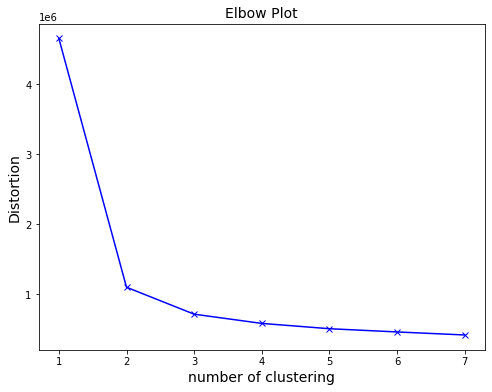

In [53]:
distortions = []
for i in range(1,8):
    km = KMeans (
        n_clusters=i, 
        init='random', 
        max_iter = 300, 
        n_init=10, 
        random_state = 0
    ).fit(X_train)
    distortions.append(km.inertia_)
    
plt.figure(figsize=(8,6))
plt.plot(range(1,8), distortions, 'bx-')
plt.xlabel('number of clustering', fontsize = 14)
plt.ylabel('Distortion', fontsize = 14)
plt.title('Elbow Plot', fontsize = 14)

In [54]:
km = KMeans (
        n_clusters=3, 
        init='random', 
        max_iter = 300, 
        n_init=10, 
        random_state = 0
    ).fit(X_train)
#y_km = km.fit_predict(X_test)
y_km_train = km.fit_predict(X_train)
y_km_test = km.fit_predict(X_test)

In [55]:
len(y_km_train)+len(y_km_test)

5592

In [56]:
Y_train['cluster'] = y_km_train
Y_test['cluster'] = y_km_test
cluster_data = pd.concat([Y_train,Y_test])
cluster_data

<ipython-input-56-00fa9745b356>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train['cluster'] = y_km_train
<ipython-input-56-00fa9745b356>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test['cluster'] = y_km_test


,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,cluster
20919,203473,2018-19,1610612737,ATL,0
21958,1626174,2016-17,1610612766,CHA,1
20439,203078,2013-14,1610612764,WAS,2
8365,2561,2013-14,1610612754,IND,2
20243,202704,2012-13,1610612760,OKC,1
...,...,...,...,...,...
18808,201572,2013-14,1610612751,BKN,1
7853,2403,2004-05,1610612743,DEN,1
7421,2202,2010-11,1610612756,PHX,0
22340,1627832,2017-18,1610612761,TOR,1


In [57]:
player_cluster = pd.merge(player_data, cluster_data, on=["PLAYER_ID", "SEASON_ID","TEAM_ID_x","TEAM_ABBREVIATION"])

In [58]:
player_cluster['cluster'].value_counts()

1    3207
2    1437
0    1074
Name: cluster, dtype: int64

In [59]:
player_cluster[player_cluster['cluster']==0].describe()

,PLAYER_ID,TEAM_ID_x,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,cluster
count,1.074000e+03,1.074000e+03,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,...,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.0
mean,2.232955e+05,1.610613e+09,27.096834,59.662011,35.170391,1511.946927,5.270298,11.660521,0.455003,1.032123,...,2.033520,3.228864,13.990596,78.931099,224.914339,10.243017,10.107821,2.264246,4.285382,0.0
std,4.194978e+05,8.350039e+00,4.248779,16.424538,10.631847,451.721563,1.429871,3.099921,0.057973,0.891433,...,0.691995,0.985309,3.923136,3.542697,27.551090,4.153797,5.153236,1.659323,2.172492,0.0
min,5.600000e+01,1.610613e+09,19.000000,14.000000,14.000000,406.000000,1.200000,2.800000,0.285000,0.000000,...,0.500000,1.100000,3.200000,70.000000,161.000000,1.000000,0.000000,0.100000,0.000000,0.0
25%,2.297000e+03,1.610613e+09,24.000000,48.000000,26.000000,1179.500000,4.200000,9.500000,0.415000,0.000000,...,1.500000,2.500000,11.300000,76.000000,205.000000,7.000000,6.500000,1.000000,2.700000,0.0
50%,2.007520e+05,1.610613e+09,27.000000,61.000000,35.000000,1526.500000,5.200000,11.600000,0.446000,1.000000,...,2.000000,3.100000,13.850000,79.000000,225.000000,10.000000,8.900000,1.700000,3.900000,0.0
75%,2.026838e+05,1.610613e+09,30.000000,74.000000,44.000000,1820.750000,6.200000,13.700000,0.485750,1.800000,...,2.400000,3.800000,16.400000,82.000000,245.000000,13.000000,12.775000,3.100000,5.400000,0.0
max,1.629066e+06,1.610613e+09,42.000000,82.000000,57.000000,2702.000000,9.500000,21.300000,0.671000,3.800000,...,5.400000,7.700000,28.700000,90.000000,325.000000,22.000000,31.800000,10.300000,14.200000,0.0


In [60]:
player_cluster[player_cluster['cluster']==1].describe()

,PLAYER_ID,TEAM_ID_x,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,cluster
count,3.207000e+03,3.207000e+03,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,...,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.0
mean,3.346836e+05,1.610613e+09,26.725288,40.350483,3.999688,663.034924,4.595666,10.867415,0.421487,0.978422,...,1.967228,3.942251,12.186374,78.980667,222.578422,7.627378,6.932710,1.479482,3.160742,1.0
std,5.397220e+05,8.838630e+00,4.475795,25.046557,5.340759,567.905476,2.193513,3.669253,0.114034,1.588064,...,1.311859,2.000914,5.803657,3.555495,27.352052,4.751324,4.223375,1.317748,1.852663,0.0
min,1.500000e+01,1.610613e+09,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,65.000000,133.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2.570000e+03,1.610613e+09,23.000000,18.000000,0.000000,169.000000,3.500000,8.700000,0.379000,0.000000,...,1.300000,2.800000,9.500000,76.000000,200.000000,4.000000,3.900000,0.600000,1.900000,1.0
50%,2.012020e+05,1.610613e+09,26.000000,39.000000,1.000000,522.000000,4.500000,10.700000,0.423000,0.700000,...,1.800000,3.600000,12.000000,79.000000,221.000000,7.000000,6.100000,1.000000,2.800000,1.0
75%,2.031240e+05,1.610613e+09,30.000000,63.000000,6.000000,1043.500000,5.550000,12.900000,0.475000,1.700000,...,2.400000,4.800000,14.700000,82.000000,240.000000,11.000000,8.900000,2.000000,4.000000,1.0
max,1.629541e+06,1.610613e+09,44.000000,82.000000,24.000000,2678.000000,69.700000,69.700000,1.000000,69.700000,...,28.200000,41.100000,209.000000,90.000000,310.000000,22.000000,26.700000,11.200000,14.200000,1.0


In [61]:
player_cluster[player_cluster['cluster']==2].describe()

,PLAYER_ID,TEAM_ID_x,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,cluster
count,1.437000e+03,1.437000e+03,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,...,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.0
mean,1.649161e+05,1.610613e+09,27.091162,74.002784,71.574113,2399.673626,6.241962,13.288448,0.471672,1.125400,...,2.167850,2.733194,16.797564,78.988866,225.398747,11.993041,13.553793,3.184690,5.245929,2.0
std,3.146640e+05,8.659736e+00,3.999222,7.683230,8.725278,411.654925,1.652848,3.416084,0.053219,0.967567,...,0.714764,0.763845,4.735248,3.597026,27.442222,4.007994,6.220224,2.218814,2.505636,0.0
min,5.600000e+01,1.610613e+09,19.000000,51.000000,50.000000,991.000000,1.100000,2.900000,0.352000,0.000000,...,0.500000,1.000000,3.300000,70.000000,161.000000,2.000000,0.200000,0.200000,0.100000,2.0
25%,2.225000e+03,1.610613e+09,24.000000,69.000000,65.000000,2097.000000,5.100000,10.900000,0.436000,0.100000,...,1.700000,2.200000,13.400000,76.000000,205.000000,9.000000,8.700000,1.500000,3.300000,2.0
50%,1.011610e+05,1.610613e+09,27.000000,76.000000,74.000000,2414.000000,6.100000,13.200000,0.462000,1.100000,...,2.100000,2.600000,16.400000,79.000000,225.000000,12.000000,12.800000,2.300000,4.700000,2.0
75%,2.019800e+05,1.610613e+09,30.000000,80.000000,80.000000,2702.000000,7.300000,15.600000,0.500000,1.800000,...,2.600000,3.100000,19.700000,82.000000,245.000000,15.000000,17.100000,4.600000,6.700000,2.0
max,1.629029e+06,1.610613e+09,40.000000,82.000000,82.000000,3424.000000,11.000000,24.900000,0.714000,5.500000,...,5.700000,7.600000,35.400000,90.000000,325.000000,22.000000,31.800000,11.200000,14.200000,2.0


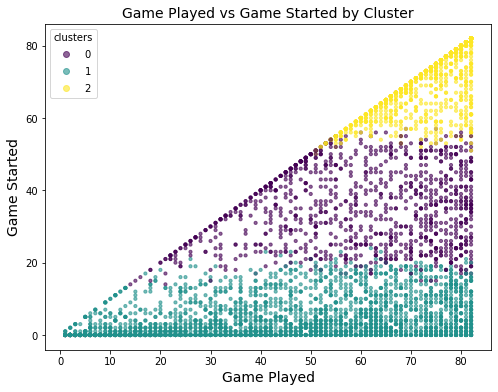

In [62]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(player_cluster.GP, player_cluster.GS, c=player_cluster.cluster, alpha = 0.6, s=10)
ax.set_title('Game Played vs Game Started by Cluster', fontsize = 14)
ax.set_ylabel('Game Started', fontsize = 14)
ax.set_xlabel('Game Played', fontsize = 14)
ax.legend(*sc.legend_elements(), title='clusters')

C:\Users\mattk\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Users\mattk\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\mattk\anaconda3\lib\site-packages\matplotlib\ticker.py:652: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


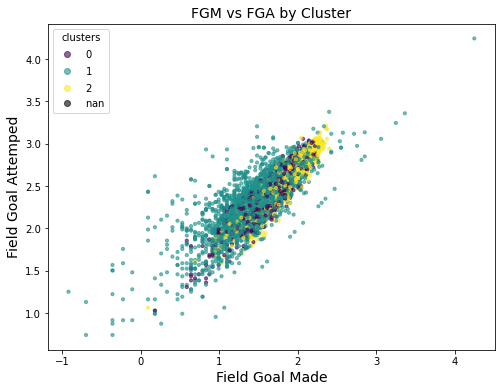

In [63]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(np.log(player_cluster.FGM), np.log(player_cluster.FGA), c=player_cluster.cluster, alpha = 0.6, s=10)
ax.set_title('FGM vs FGA by Cluster', fontsize = 14)
ax.set_ylabel('Field Goal Attemped', fontsize = 14)
ax.set_xlabel('Field Goal Made', fontsize = 14)
ax.legend(*sc.legend_elements(), title='clusters')

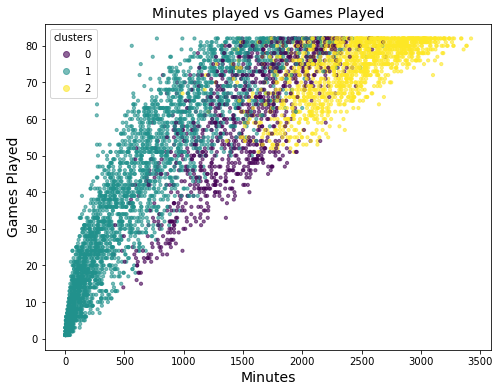

In [71]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(player_cluster.MIN, player_cluster.GP, c=player_cluster.cluster, alpha = 0.6, s=10)
ax.set_title('Minutes played vs Games Played', fontsize = 14)
ax.set_ylabel('Games Played', fontsize = 14)
ax.set_xlabel('Minutes', fontsize = 14)
ax.legend(*sc.legend_elements(), title='clusters')

In [75]:
pca = PCA(n_components=3)
train_pca = pca.fit_transform(X_train)
test_pca = pca.transform(X_test)

gmm=GaussianMixture(n_components = 3, covariance_type='full', random_state=12345).fit(train_pca)


In [80]:
grouped_clusters = player_cluster.groupby('cluster')